#Assignment 1:
    Test if the distribution of ages is the same for 
    
    1) male and female riders
    
    2) day and night riders
    
    Use 3 tests: KS, Pearson's, Spearman's

my usual imports and setups

In [100]:
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline
from __future__ import division
import os
import datetime as dtt

#this makes my plots pretty! but it is totally not mandatory to do it
import json
#s = json.load(open(os.getenv ('PUI2015') + open("/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib


I am reading in data from January 2015. It would be a good idea to use data from warmer months, since there are more riders in the warm weather and the more data the smaller the STATISTICAL NOISE. If you are ambitious you can use data from multiple months, thus addressing systematic errors as well

In [89]:
df=pd.read_csv('201501-citibike-tripdata.csv')
print df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')


#BY GENDER
splitting data by gender and extracting the age happens in the cell below

In [90]:
#df is the dataframe where the content of the csv file is stored
df['ageM'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 1)]
df['ageF'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 2)]

lets splot age in 10 year bins. the dataset is very large, so i could be split in smaller bins, but I will chose 10 years in the interest of time. if i was to do this "for real" the bin size choice should be a balance between properly sample the age space, have enough counts in each bin that the statistical noise is not significant (remember that is > sqrt(N)!) and the computational requirement to computatinal facilities ratio. 

the next several steps are needed if you want to code up the KS test from scratch. that is for extra credit, so if you do not want to do it you may not need to plot split the distribution in bins and create the cumulative HOWEVER it is a great idea to do it anyways to explore your data viaually! remember Ascombe's quartet!!

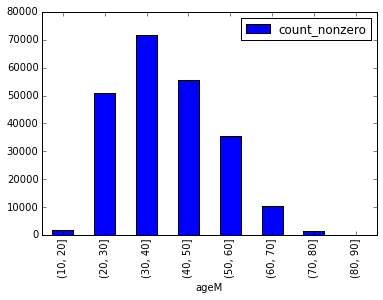

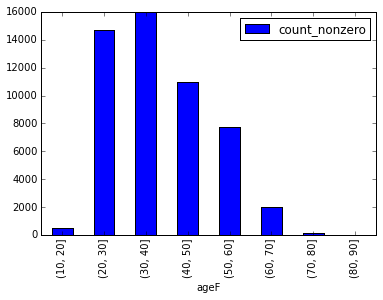

In [91]:
bins = np.arange(10, 99, 10)
df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).plot(kind='bar')
df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).plot(kind='bar')

this is how the cumulative distributions look like.  Notice that i am normalizing them! if i want to reat an observed distribution like a probablility distribution i have to normalize it

          count_nonzero
ageM                   
(10, 20]       0.001656
(20, 30]       0.060938
(30, 40]       0.052105
(40, 50]       0.018598
(50, 60]       0.010887
(60, 70]       0.003129
(70, 80]       0.000113
(80, 90]       0.000000


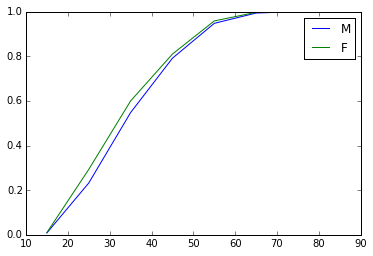

In [92]:
#print df.ageS, df.ageS.cumsum()

csM=df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).cumsum()

csF=df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).cumsum()

print np.abs(csM / csM.max()- csF / csF.max())

pl.plot(bins[:-1] + 5, csM / csM.max(), label = "M")
pl.plot(bins[:-1] + 5, csF / csF.max(), label = "F")
pl.legend()

they look pretty darn similar! that sets my expectation for the tests to come. if i wanted to code the KS test by hand i woud have everything i need: the normalized cumulative distributions can be subtracted from each other and the max distance can be seeked. 

Notice that there amay be Nan values you are gonna have to deal with! you can do that for example with a Boolean statementsuch as  df.ageF[~np.isnan(df.ageF)] or you can use numpy functions that deal with Nan values: nansum, nanmean, nanstd...

lets run the scipy KS test

In [93]:
import scipy.stats

#KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html


In [94]:
ks=scipy.stats.ks_2samp(df.ageM, df.ageF)
print ks

Ks_2sampResult(statistic=0.61519793242561782, pvalue=0.0)


remember: the Null hypothesis is rejected if 

$D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$

where $c(\alpha$) is the inverse of the KS distribution, and you do not have to know how to get that cause there are tables that list critical values!! 

http://www.real-statistics.com/tests-normality-and-symmetry/statistical-tests-normality-symmetry/kolmogorov-smirnov-test/kolmogorov-distribution/

but scipy is already giving you the p-value, s you do not have to worry about it i am still giving you the table FYI and if you want to do the coding of the KS test by hand


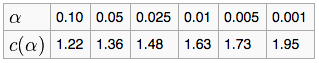

In [95]:
#here is the critical values table. Have you chosen your significance level yet?? you should do it first thing!
from IPython.display import Image
Image(filename="k2sample_table.png")

In [96]:
##this cell is for you to tell me what the scipy KS test returned and what it means
n1 = len(df.ageF) - np.isnan(df.ageF).sum()
n2 = len(df.ageM) - np.isnan(df.ageM).sum()

print 1.95*sqrt(((n1+n2)/(n1*n2)))

0.00947044690114


###R:// What it means
The KS statistic 0.615 is bigger than $c(\alpha) \sqrt{\frac{n1+n2}{n1n2}}$, that using a level of confidence of 0.001 (a $c(\alpha)$ of 1.22), approximates 0.0095. This means that the p-value is less than 1%, and this is the reason why the scipy KS test returns a p-value of zero. This means that the hypothesis is rejected at an almost 0% confidence level.

#Pearson's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



In [97]:
#please perform the Pearson's test 
Age_FST = (df.ageF-mean(df.ageF))/std(df.ageF)
Age_MST = (df.ageM-mean(df.ageM))/std(df.ageM)
Age_FST = Age_FST.dropna()
Age_MST = Age_MST.dropna()

pr = scipy.stats.pearsonr(np.array(Age_FST),np.array(Age_MST[0:len(Age_FST)]))

print "Pearson coef=", pr[0], ". P-value= ", pr[1]

Pearson coef= 0.000693381193637 . P-value=  0.874257607931


*...And tell me what you find*

I find no correlation, as expected. **Note:** I did "force" the data into two "distributions" but probably a z-test could be performed in order to see if the subset of men is a representative subset of the entire population of men.

Also: as it was expected, the non correlation hypothesis was not rejected with a very high p-value, meaning that both distributions are not correlated. Note that if I force it, since the two data sets are so big, the correlation is actually pretty high (basically because there are women and men of all ages). This test does not say much but it was just to show how to perform various tests - I suppose.

#Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

In [98]:
#please perform the Spearman's test and tell me what you find
print scipy.stats.spearmanr(np.array(Age_FST),np.array(Age_MST[0:len(Age_FST)]), axis=0)
print scipy.stats.spearmanr(np.sort(np.array(Age_FST)),np.sort(np.array(Age_MST[0:len(Age_FST)])), axis=0) 

SpearmanrResult(correlation=0.0013742691298006162, pvalue=0.75378360630653196)
SpearmanrResult(correlation=0.99912537548253844, pvalue=0.0)


##please comment on the numbers that you get in the light of the scipy manual: what is rerutned? what does it mean??

##DO THE SAME FOR THE DISTRIBUTION OF RIDERS DURING THE DAY VS DURING THE NIGHT!

hint: remember how I converted the starttime last time in my own citibikes notebook into units that are easy to read. 
df['mystarttime'] = ...
then you can use something like
df['mystarttime'].dt.hour

In [164]:
tm_temp= [str.split(i)[1] for i in df.starttime] # Separate dates from hours
df['time']= [dtt.datetime.strptime(i,"%H:%M").hour for i in tm_temp]
df['ageNight'] = 2015-df['birth year'][(df['time'] < 5) | (df['time'] > 18)]
df['ageDay'] = 2015-df['birth year'][(df['time'] > 5) | (df['time'] < 18)]

nightAge=df.ageNight.groupby(pd.cut(df.ageNight, bins)).agg([count_nonzero]).cumsum()
dayAge=df.ageDay.groupby(pd.cut(df.ageDay, bins)).agg([count_nonzero]).cumsum()


          count_nonzero
ageDay                 
(10, 20]           2474
(20, 30]          68104
(30, 40]         155894
(40, 50]         222313
(50, 60]         265629
(60, 70]         278177
(70, 80]         279728
(80, 90]         279786


          count_nonzero
ageNight               
(10, 20]       0.002286
(20, 30]       0.079761
(30, 40]       0.099210
(40, 50]       0.056452
(50, 60]       0.013859
(60, 70]       0.002029
(70, 80]       0.000043
(80, 90]       0.000000


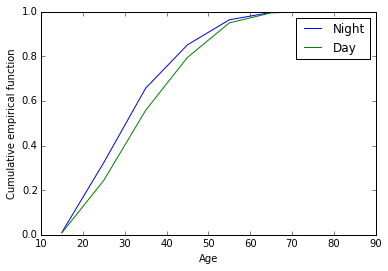

In [169]:
#Plotting the distributions

print np.abs(nightAge / nightAge.max()- dayAge / dayAge.max())

pl.plot(bins[:-1] + 5, nightAge / nightAge.max(), label = "Night")
pl.plot(bins[:-1] + 5, dayAge / dayAge.max(), label = "Day")
pl.xlabel("Age")
pl.ylabel("Cumulative empirical function")
pl.legend()

In [170]:
#KS Test
ks=scipy.stats.ks_2samp(df.ageDay, df.ageNight)
print ks

Ks_2sampResult(statistic=0.79865663696979883, pvalue=0.0)


In [173]:
##this cell is for you to tell me what the scipy KS test returned and what it means
n1 = len(df.ageDay) - np.isnan(df.ageDay).sum()
n2 = len(df.ageNight) - np.isnan(df.ageNight).sum()

print "c(a).sqrt... =", 1.95*sqrt(((n1+n2)/(n1*n2)))

c(a).sqrt... = 0.00932190799054


The hypothesis is rejected

In [175]:
#Pearson 
#please perform the Pearson's test 
Age_DST = (df.ageDay-mean(df.ageDay))/std(df.ageDay)
Age_NST = (df.ageNight-mean(df.ageNight))/std(df.ageNight)
Age_DST = Age_DST.dropna()
Age_NST = Age_NST.dropna()

pr = scipy.stats.pearsonr(np.array(Age_NST),np.array(Age_DST[0:len(Age_NST)]))

print "Pearson coef=", pr[0], ". P-value= ", pr[1]

Pearson coef= 0.00944836521296 . P-value=  0.0314149164582


In [176]:
#Spearman
print scipy.stats.spearmanr(np.array(Age_FST),np.array(Age_MST[0:len(Age_FST)]), axis=0)
print scipy.stats.spearmanr(np.sort(np.array(Age_FST)),np.sort(np.array(Age_MST[0:len(Age_FST)])), axis=0) 

SpearmanrResult(correlation=0.0013742691298006162, pvalue=0.75378360630653196)
SpearmanrResult(correlation=0.99912537548253844, pvalue=0.0)
